In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import h5py
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.utils import shuffle
import joblib
import time
from fastai.tabular.all import *
import gc

#### Configurations

In [2]:
# Set a fixed seed for reproducibility -> This assures consistent results on the training data
fixed_seed = 42
np.random.seed(fixed_seed)

#### Specify path to the dataset

In [3]:
# Specify the correct path to your file on Kaggle
path = '/kaggle/input/zparticlesearch/mc_110901.ZPrime500/'

#### List background and signal files
The Monte Carlo simulated datasets are available at Cern opendata (CMS Open Data). See the dataset details for more info. Each dataset has a description of what the datasets simulates. This way we could easily distict between background and signal files, where signal files are the simulated data that may prove the presense of the hypothetical Z' particle.

In [4]:
# List of background files
background_files = [
    'mc_105986.ZZ.hdf5',
    'mc_105987.WZ.hdf5',
    'mc_110090.stop_tchan_top.hdf5',
    'mc_110091.stop_tchan_antitop.hdf5',
    'mc_110119.stop_schan.hdf5',
    'mc_110140.stop_wtchan.hdf5',
    'mc_117049.ttbar_had.hdf5',
    'mc_117050.ttbar_lep.hdf5',
    'mc_147770.Zee.hdf5',
    'mc_147771.Zmumu.hdf5',
    'mc_147772.Ztautau.hdf5',
    'mc_167740.WenuWithB.hdf5',
    'mc_167743.WmunuWithB.hdf5',
    'mc_167746.WtaunuWithB.hdf5',
    'mc_173041.DYeeM08to15.hdf5',
    'mc_173042.DYeeM15to40.hdf5',
    'mc_173043.DYmumuM08to15.hdf5',
    'mc_173044.DYmumuM15to40.hdf5',
    'mc_173045.DYtautauM08to15.hdf5',
    'mc_173046.DYtautauM15to40.hdf5'
]


# List of signal files
signal_files = [
    'mc_110901.ZPrime500.hdf5',
    'mc_110902.ZPrime750.hdf5',
    'mc_110903.ZPrime1000.hdf5',
    'mc_110905.ZPrime1500.hdf5',
    'mc_110906.ZPrime1750.hdf5',
    'mc_110907.ZPrime2000.hdf5',
    'mc_110909.ZPrime2500.hdf5'
]

### Load and prepare the data

In [5]:
def load_subset_data(file_list, label, subset_percentage):
    df_combined = pd.DataFrame()
    for file in file_list:
        with h5py.File(path + file, 'r') as f:
            data = f['mini'][:]
        
        # Determine the subset size based on the percentage
        subset_size = int(len(data) * subset_percentage)
        
        # Take a random subset of data
        np.random.shuffle(data)
        data = data[:subset_size]
        
        data_df = pd.DataFrame(data)
        data_df['label'] = label
        df_combined = pd.concat([df_combined, data_df])
    return df_combined

In [23]:
# Load a subset of background and signal data - set the percentage here
subset_percentage = 0.1
df_background = load_subset_data(background_files, 0, subset_percentage)
df_signal = load_subset_data(signal_files, 1, subset_percentage)

# Combine background and signal data
df_combined = pd.concat([df_background, df_signal])

# Shuffle the combined DataFrame
df_combined = shuffle(df_combined, random_state=fixed_seed)

# Free up RAM by deleting the dataframes
del df_background
del df_signal
gc.collect()

2175

#### Define excluded features (These are selected from part 1)

In [24]:
# Define excluded features
excluded_features = [
    'eventWeight', 
    'mcWeight', 
    'channelNumber', 
    'runNumber', 
    'data_type', 
    'label', 
    'eventNumber', 
    'jet_6_SV0', 
    'jet_7_SV0', 
    'jet_8_SV0', 
    'jet_9_SV0', 
    'jet_8_trueflav', 
    'jet_9_trueflav',
    'lep_4_E',                       
    'lep_4_charge',            
    'lep_4_eta',                     
    'lep_4_etcone20',                
    'lep_4_flag',                   
    'lep_4_phi',                     
    'lep_4_pt',                      
    'lep_4_ptcone30',                
    'lep_4_trackd0pvunbiased',       
    'lep_4_tracksigd0pvunbiased',    
    'lep_4_type',                   
    'lep_4_z0',                     
    'lep_5_E',                       
    'lep_5_charge',                  
    'lep_5_eta',                     
    'lep_5_etcone20',             
    'lep_5_flag',                    
    'lep_5_phi',                     
    'lep_5_pt',                      
    'lep_5_ptcone30',             
    'lep_5_trackd0pvunbiased',      
    'lep_5_tracksigd0pvunbiased',   
    'lep_5_type',                    
    'lep_5_z0',                                        
    'lep_trigMatched',      
    'jet_1_trueflav',                
    'jet_1_truthMatched',            
    'jet_2_trueflav',                
    'jet_2_truthMatched',            
    'jet_3_trueflav',                
    'jet_3_truthMatched',            
    'jet_4_trueflav',                
    'jet_4_truthMatched',            
    'jet_5_trueflav',                
    'jet_5_truthMatched',            
    'jet_6_trueflav',                
    'jet_6_truthMatched',            
    'jet_7_trueflav',                
    'jet_7_truthMatched',            
    'jet_8_trueflav',                
    'jet_8_truthMatched',            
    'jet_9_trueflav',                
    'jet_9_truthMatched',            
    'runNumber',                     
    'scaleFactor_BTAG',              
    'scaleFactor_ELE',               
    'scaleFactor_JVFSF',             
    'scaleFactor_MUON',              
    'scaleFactor_PILEUP',            
    'scaleFactor_TRIGGER',           
    'scaleFactor_ZVERTEX'
] 

# Select features for training
features = [col for col in df_combined.columns if col not in excluded_features]

#### Prepare Data for Training

In [25]:
# Assuming df_combined is your combined DataFrame with features and labels
X = df_combined[features]
y = df_combined['label']

# Convert the feature matrix (X) and the target vector (y) into a FastAI TabularPandas object
procs = [Categorify, FillMissing, Normalize]  # Preprocessing steps: categorify categorical variables, fill missing values, normalize

metrics = [accuracy, Precision(), Recall(), F1Score()]

# Split data into training and validation sets
splits = RandomSplitter(valid_pct=0.4)(range_of(df_combined))  # Split data into training and validation sets

# FastAI needs the data in a single DataFrame, so let's combine X and y again for convenience
df_combined['label'] = y

to = TabularPandas(df_combined, procs=procs, cat_names=None, cont_names=features, y_names="label", splits=splits, y_block=CategoryBlock)

# Create a dataloader
dls = to.dataloaders(bs=256)  # bs is the batch size

#### Train the model

Minimum/10: 1.4e-03, Steepest point: 8.3e-02


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.018714,0.016228,0.995278,0.758498,0.495112,0.599136,02:00
1,0.013242,0.016609,0.995110,0.902187,0.352056,0.506473,01:48
2,0.013141,0.015764,0.995534,0.859361,0.446548,0.587707,02:00
3,0.014343,0.014362,0.995622,0.847401,0.470442,0.605008,02:06
4,0.013194,0.014599,0.995583,0.834197,0.474631,0.605024,01:52
5,0.013337,0.014607,0.995607,0.825823,0.486268,0.612109,02:01


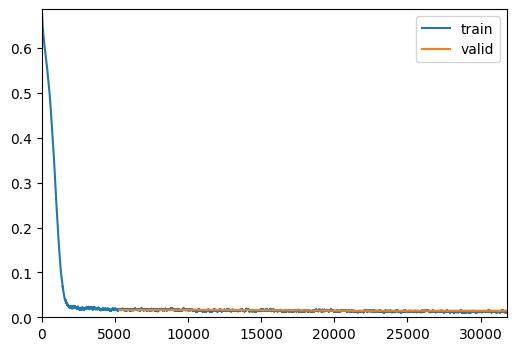

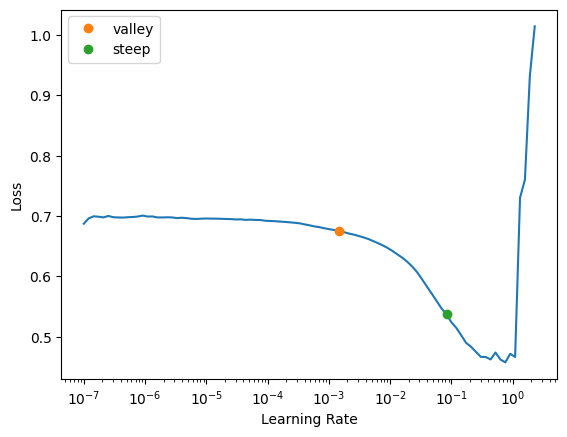

In [26]:
# Define the learner
learn = tabular_learner(dls, metrics=metrics, layers=[200,100], cbs=ShowGraphCallback())

# Find and plot the optimal learning rate
lr_min, lr_steep = learn.lr_find(suggest_funcs=(valley, steep))
print(f"Minimum/10: {lr_min:.1e}, Steepest point: {lr_steep:.1e}")

# Train the model with the new batch size and an adjusted learning rate
learn.fit_one_cycle(6, lr_max=lr_min)

#### Evaluate the model

Validation Accuracy: 0.9956


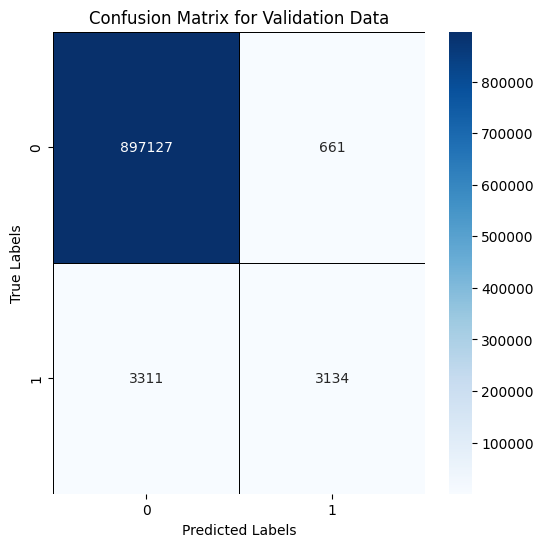

In [27]:
# First, get the predictions and actual labels from the validation set
val_preds, val_targets = learn.get_preds(dl=dls.valid)

# The actual labels (y_test_np)
y_test_np = val_targets.numpy()

# Predicted labels (convert probabilities to class indices)
y_pred_test_np = np.argmax(val_preds, axis=1).numpy()

# Calculate accuracy on the validation set
accuracy_val = accuracy_score(y_test_np, y_pred_test_np)
print(f"Validation Accuracy: {accuracy_val:.4f}")

# Plot the confusion matrix
conf_matrix_val = confusion_matrix(y_test_np, y_pred_test_np)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Validation Data')
plt.show()

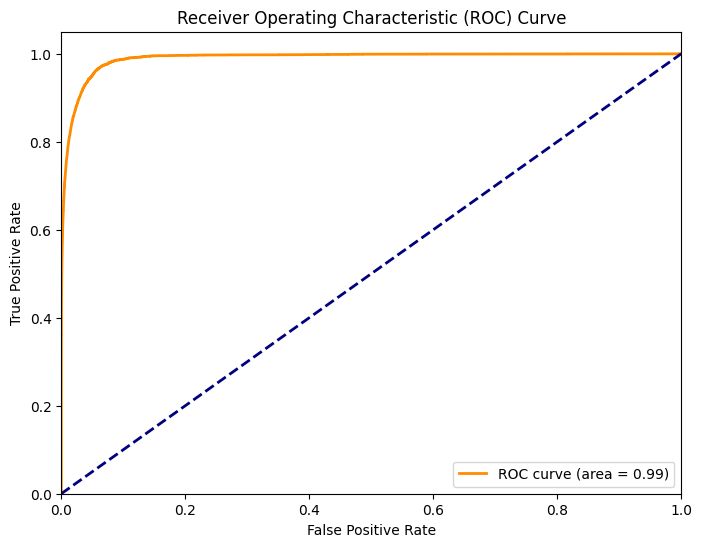

In [28]:
# Ensure val_targets is a numpy array
y_true = val_targets.numpy()

# Extract the probability scores for the positive class
y_scores = val_preds[:, 1].numpy()

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [29]:
# True Positives, False Positives, etc. from the confusion matrix
TP = conf_matrix_val[1, 1]
FP = conf_matrix_val[0, 1]
FN = conf_matrix_val[1, 0]
TN = conf_matrix_val[0, 0]

# Precision
precision = TP / (TP + FP)
# Recall
recall = TP / (TP + FN)
# F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision on Signal Predictions: {precision:.4f}")
print(f"Recall on Signal Predictions: {recall:.4f}")
print(f"F1-Score on Signal Predictions: {f1_score:.4f}")


Precision on Signal Predictions: 0.8258
Recall on Signal Predictions: 0.4863
F1-Score on Signal Predictions: 0.6121


#### As you can see, the model predics much worse on the signal files than the background files.

The model's precision is 0.8337, indicating high accuracy in predicting signals. However, its recall is 0.4990, meaning it misses almost half of the actual signal files. The high precision and low recall indicate the model is conservative, frequently missing true signal events. The F1-Score is 0.6243, showing a balance between precision and recall. There is room for improvement, especially in the model's sensitivity to signal events.

The model is reliable when detecting a signal, but it is not capturing enough signal events.


### Now we can try to balance the dataset, by using the same technique as we did in part 1 (undersampling)

In [ ]:
# Delete variables to free up memory
del X, y, to, dls, learn, lr_min, lr_steep

# Free up RAM by deleting the dataframes
del df_combined
gc.collect()


### Undersampling
By undersampling, we can improve the models performance on predicting signal events, especially since the dataset is so heavily unbalanced. However, making a 50/50 balance is not a good idea, because even if the model predics very well on this balanced data, using that model will later not work so well on a more unbalanced dataset again. Because of this we have tested adding a ratio with for example 5 times more background files as signal files. Originally the data imbalance has a 1 to 137 relation as we saw on during loading the dataframe on the baseline model.

In [6]:
# Define the background to signal ratio
background_to_signal_ratio = 10  # 10 will give 10 times more background than signal data

# Load all signal data and add label
df_signal_list = []
for file in signal_files:
    with h5py.File(f"{path}/{file}", 'r') as f:
        data = pd.DataFrame(f['mini'][:])
        data['label'] = 1  # Assigning '1' to signal label
        df_signal_list.append(data)

# Concatenate all signal data into a single DataFrame
df_signal = pd.concat(df_signal_list, ignore_index=True)

# Determine the number of background entries to match the signal data size
total_signal_entries = len(df_signal)
background_entries_needed_per_file = (total_signal_entries // len(background_files) * background_to_signal_ratio)

# Load a balanced subset of background data and add label
df_background_list = []
for file in background_files:
    with h5py.File(f"{path}/{file}", 'r') as f:
        data = pd.DataFrame(f['mini'][:])
        # Ensure not to exceed available entries and only take a sample if necessary
        entries_to_sample = min(len(data), background_entries_needed_per_file)
        sampled_data = data.sample(n=entries_to_sample, random_state=fixed_seed)  # Same random sampling as old code
        sampled_data['label'] = 0  # Assigning '0' to background label
        df_background_list.append(sampled_data)

# Concatenate all background data into a single DataFrame
df_background = pd.concat(df_background_list, ignore_index=True)

# Combine signal and background data
df_combined = pd.concat([df_signal, df_background], ignore_index=True)

# Shuffle the combined DataFrame
df_combined = shuffle(df_combined, random_state=fixed_seed).reset_index(drop=True)

In [7]:
# Count the number of signal and background entries
signal_count = df_combined[df_combined['label'] == 1].shape[0]
background_count = df_combined[df_combined['label'] == 0].shape[0]

print(f"Number of signal entries: {signal_count}")
print(f"Number of background entries: {background_count}")

Number of signal entries: 163308
Number of background entries: 1455606


#### Make sure the features are updated

In [8]:
# Define excluded features
excluded_features = [
    'eventWeight', 
    'mcWeight', 
    'channelNumber', 
    'runNumber', 
    'data_type', 
    'label', 
    'eventNumber', 
    'jet_6_SV0', 
    'jet_7_SV0', 
    'jet_8_SV0', 
    'jet_9_SV0', 
    'jet_8_trueflav', 
    'jet_9_trueflav',
    'lep_4_E',                       
    'lep_4_charge',            
    'lep_4_eta',                     
    'lep_4_etcone20',                
    'lep_4_flag',                   
    'lep_4_phi',                     
    'lep_4_pt',                      
    'lep_4_ptcone30',                
    'lep_4_trackd0pvunbiased',       
    'lep_4_tracksigd0pvunbiased',    
    'lep_4_type',                   
    'lep_4_z0',                     
    'lep_5_E',                       
    'lep_5_charge',                  
    'lep_5_eta',                     
    'lep_5_etcone20',             
    'lep_5_flag',                    
    'lep_5_phi',                     
    'lep_5_pt',                      
    'lep_5_ptcone30',             
    'lep_5_trackd0pvunbiased',      
    'lep_5_tracksigd0pvunbiased',   
    'lep_5_type',                    
    'lep_5_z0',                                             
    'lep_trigMatched',      
    'jet_1_trueflav',                
    'jet_1_truthMatched',            
    'jet_2_trueflav',                
    'jet_2_truthMatched',            
    'jet_3_trueflav',                
    'jet_3_truthMatched',            
    'jet_4_trueflav',                
    'jet_4_truthMatched',            
    'jet_5_trueflav',                
    'jet_5_truthMatched',            
    'jet_6_trueflav',                
    'jet_6_truthMatched',            
    'jet_7_trueflav',                
    'jet_7_truthMatched',            
    'jet_8_trueflav',                
    'jet_8_truthMatched',            
    'jet_9_trueflav',                
    'jet_9_truthMatched',            
    'runNumber',                     
    'scaleFactor_BTAG',              
    'scaleFactor_ELE',               
    'scaleFactor_JVFSF',             
    'scaleFactor_MUON',              
    'scaleFactor_PILEUP',            
    'scaleFactor_TRIGGER',           
    'scaleFactor_ZVERTEX'
] 

# Select features for training
features = [col for col in df_combined.columns if col not in excluded_features]

#### Prepare the undersampled data for training

In [9]:
X = df_combined[features]
y = df_combined['label']

# Convert the feature matrix (X) and the target vector (y) into a FastAI TabularPandas object
procs = [Categorify, FillMissing, Normalize]  # Preprocessing steps: categorify categorical variables, fill missing values, normalize

metrics = [accuracy, Precision(), Recall(), F1Score()]

# Split data into training and validation sets
splits = RandomSplitter(valid_pct=0.4, seed=fixed_seed)(range_of(df_combined)) # Use the fixed seed for the RandomSplitter

# FastAI needs the data in a single DataFrame, so let's combine X and y again for convenience
df_combined['label'] = y

to = TabularPandas(df_combined, procs=procs, cat_names=None, cont_names=features, y_names="label", splits=splits, y_block=CategoryBlock)

# Create a dataloader
dls = to.dataloaders(bs=256)  # bs is the batch size

#### Train the model

Minimum/10: 1.4e-03, Steepest point: 2.8e-02


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.084790,0.077733,0.968470,0.882071,0.792006,0.834616,01:20
1,0.053226,0.049308,0.981103,0.914512,0.895603,0.904959,01:31
2,0.038326,0.037293,0.986108,0.930073,0.931760,0.930916,01:35
3,0.026410,0.029325,0.989462,0.945017,0.950392,0.947697,01:18
4,0.020494,0.025159,0.991042,0.953730,0.957264,0.955494,01:23
5,0.017916,0.024423,0.991386,0.958917,0.955173,0.957041,01:32


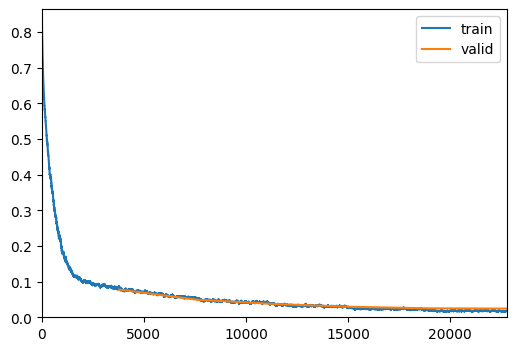

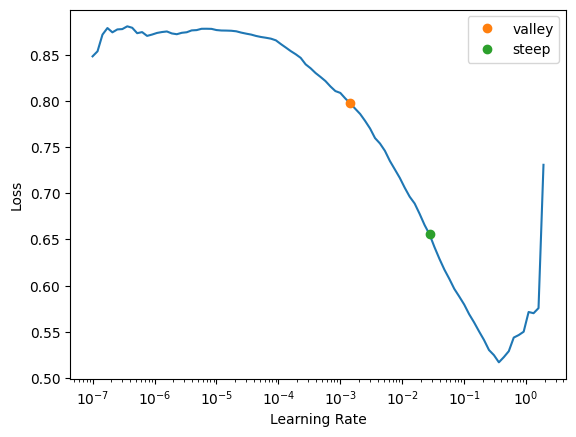

In [10]:
# Define the learner
learn = tabular_learner(dls, metrics=metrics, layers=[200,100], cbs=ShowGraphCallback())

# Find and plot the optimal learning rate
lr_min, lr_steep = learn.lr_find(suggest_funcs=(valley, steep))
print(f"Minimum/10: {lr_min:.1e}, Steepest point: {lr_steep:.1e}")

# Train the model with the new batch size and an adjusted learning rate
learn.fit_one_cycle(6, lr_max=lr_min)

#### Evaluate the model

Validation Accuracy: 0.9914


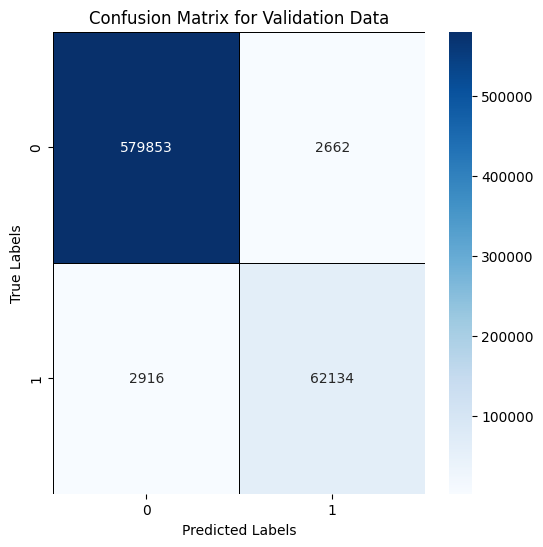

In [11]:
# First, get the predictions and actual labels from the validation set
val_preds, val_targets = learn.get_preds(dl=dls.valid)

# The actual labels (y_test_np)
y_test_np = val_targets.numpy()

# Predicted labels (convert probabilities to class indices)
y_pred_test_np = np.argmax(val_preds, axis=1).numpy()

# Calculate accuracy on the validation set
accuracy_val = accuracy_score(y_test_np, y_pred_test_np)
print(f"Validation Accuracy: {accuracy_val:.4f}")

# Plot the confusion matrix
conf_matrix_val = confusion_matrix(y_test_np, y_pred_test_np)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Validation Data')
plt.show()

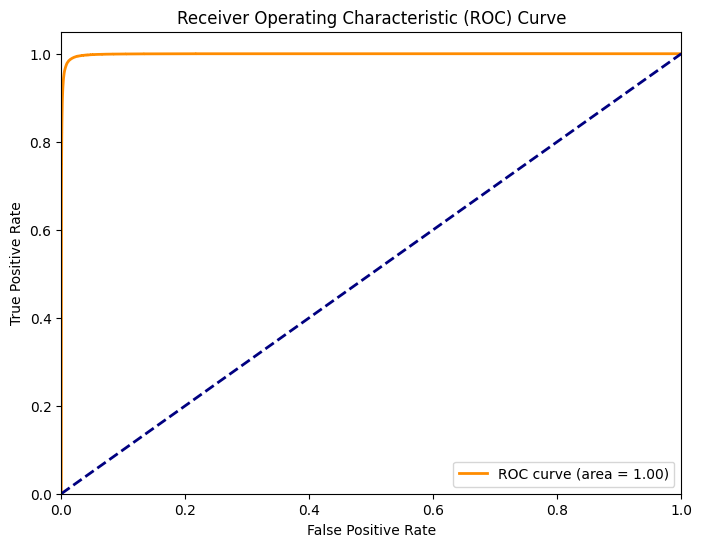

In [12]:
# Ensure val_targets is a numpy array
y_true = val_targets.numpy()

# Extract the probability scores for the positive class
y_scores = val_preds[:, 1].numpy()

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [13]:
# True Positives, False Positives, etc. from the confusion matrix
TP = conf_matrix_val[1, 1]
FP = conf_matrix_val[0, 1]
FN = conf_matrix_val[1, 0]
TN = conf_matrix_val[0, 0]

# Precision
precision = TP / (TP + FP)
# Recall
recall = TP / (TP + FN)
# F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision on Signal Predictions: {precision:.4f}")
print(f"Recall on Signal Predictions: {recall:.4f}")
print(f"F1-Score on Signal Predictions: {f1_score:.4f}")

Precision on Signal Predictions: 0.9589
Recall on Signal Predictions: 0.9552
F1-Score on Signal Predictions: 0.9570


#### The model's performance improved significantly with the undersampling technique. The results highlight how effective undersampling is in balancing the dataset, improving discrimination between background and signal events, and enhancing model accuracy.

### Save the model

In [ ]:
# Define the name for the exported file
export_fname = 'undersampled_model-10-to-1-not5.pkl'

# Export the learner
learn.export(export_fname)

#### In part 3/3 of this notebook series, we will try to measure the mass of the Z' particle

In [15]:
# Free up RAM by deleting the dataframes
del df_background
del df_signal
del df_oversampled
gc.collect()

# Delete variables to free up memory
del X, y, to, dls, learn, lr_min, lr_steep

### Oversampling

In [6]:
# First we load a subset of background and signal data -> Just like the baseline model
subset_percentage = 0.1
df_background = load_subset_data(background_files, 0, subset_percentage)
df_signal = load_subset_data(signal_files, 1, subset_percentage)

# Combine background and signal data
df_combined = pd.concat([df_background, df_signal])

# Shuffle the combined DataFrame
df_combined = shuffle(df_combined, random_state=fixed_seed)

In [7]:
# Define excluded features
excluded_features = [
    'eventWeight', 
    'mcWeight', 
    'channelNumber', 
    'runNumber', 
    'data_type', 
    'label', 
    'eventNumber', 
    'jet_6_SV0', 
    'jet_7_SV0', 
    'jet_8_SV0', 
    'jet_9_SV0', 
    'jet_8_trueflav', 
    'jet_9_trueflav',
    'lep_4_E',                       
    'lep_4_charge',            
    'lep_4_eta',                     
    'lep_4_etcone20',                
    'lep_4_flag',                   
    'lep_4_phi',                     
    'lep_4_pt',                      
    'lep_4_ptcone30',                
    'lep_4_trackd0pvunbiased',       
    'lep_4_tracksigd0pvunbiased',    
    'lep_4_type',                   
    'lep_4_z0',                     
    'lep_5_E',                       
    'lep_5_charge',                  
    'lep_5_eta',                     
    'lep_5_etcone20',             
    'lep_5_flag',                    
    'lep_5_phi',                     
    'lep_5_pt',                      
    'lep_5_ptcone30',             
    'lep_5_trackd0pvunbiased',      
    'lep_5_tracksigd0pvunbiased',   
    'lep_5_type',                    
    'lep_5_z0',                                        
    'lep_trigMatched',      
    'jet_1_trueflav',                
    'jet_1_truthMatched',            
    'jet_2_trueflav',                
    'jet_2_truthMatched',            
    'jet_3_trueflav',                
    'jet_3_truthMatched',            
    'jet_4_trueflav',                
    'jet_4_truthMatched',            
    'jet_5_trueflav',                
    'jet_5_truthMatched',            
    'jet_6_trueflav',                
    'jet_6_truthMatched',            
    'jet_7_trueflav',                
    'jet_7_truthMatched',            
    'jet_8_trueflav',                
    'jet_8_truthMatched',            
    'jet_9_trueflav',                
    'jet_9_truthMatched',            
    'runNumber',                     
    'scaleFactor_BTAG',              
    'scaleFactor_ELE',               
    'scaleFactor_JVFSF',             
    'scaleFactor_MUON',              
    'scaleFactor_PILEUP',            
    'scaleFactor_TRIGGER',           
    'scaleFactor_ZVERTEX'
] 

# Select features for training
features = [col for col in df_combined.columns if col not in excluded_features]

In [8]:
from sklearn.utils import resample

# Oversample signal data to match the number of background samples
df_signal_oversampled = resample(df_signal,
                                 replace=True,                    
                                 n_samples=len(df_background),    
                                 random_state=fixed_seed)         

# Combine the oversampled signal data with the background data
df_oversampled = pd.concat([df_background, df_signal_oversampled])

# Shuffle the combined DataFrame to ensure a good mix
df_oversampled = shuffle(df_oversampled, random_state=fixed_seed).reset_index(drop=True)

In [9]:
# Count the number of signal and background entries
signal_count = df_oversampled[df_oversampled['label'] == 1].shape[0]
background_count = df_oversampled[df_oversampled['label'] == 0].shape[0]

print(f"Number of signal entries: {signal_count}")
print(f"Number of background entries: {background_count}")

Number of signal entries: 2244255
Number of background entries: 2244255


In [10]:
# Prepare the feature matrix (X) and the target vector (y)
X = df_oversampled[features]
y = df_oversampled['label']

# Convert the feature matrix (X) and the target vector (y) into a FastAI TabularPandas object
procs = [Categorify, FillMissing, Normalize]  # Preprocessing steps: categorify categorical variables, fill missing values, normalize

metrics = [accuracy, Precision(), Recall(), F1Score()]

# Split data into training and validation sets
splits = RandomSplitter(valid_pct=0.4, seed=fixed_seed)(range_of(df_oversampled)) # Use the fixed seed for the RandomSplitter

# FastAI needs the data in a single DataFrame, so let's combine X and y again for convenience
df_oversampled['label'] = y

to = TabularPandas(df_oversampled, procs=procs, cat_names=None, cont_names=features, y_names="label", splits=splits, y_block=CategoryBlock)

# Create a dataloader
dls = to.dataloaders(bs=256)  # bs is the batch size

Minimum/10: 1.7e-03, Steepest point: 1.2e-03


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.045861,0.045259,0.985946,0.975073,0.997388,0.986104,03:52
1,0.024544,0.020455,0.994629,0.990085,0.999264,0.994653,03:53
2,0.014780,0.014483,0.996151,0.992771,0.999580,0.996164,03:57
3,0.009966,0.010940,0.997617,0.995257,1.000000,0.997623,03:56
4,0.008181,0.009059,0.998422,0.996853,1.000000,0.998424,04:05
5,0.004973,0.010397,0.998212,0.996435,1.000000,0.998215,04:04


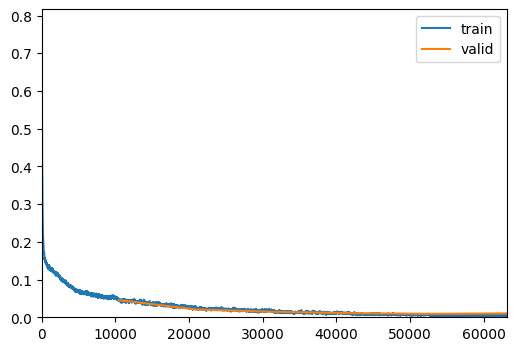

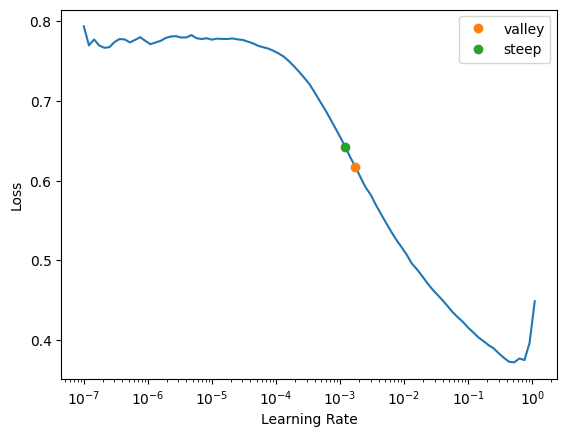

In [11]:
# Define the learner
learn = tabular_learner(dls, metrics=metrics, layers=[200,100], cbs=ShowGraphCallback())

# Find and plot the optimal learning rate
lr_min, lr_steep = learn.lr_find(suggest_funcs=(valley, steep))
print(f"Minimum/10: {lr_min:.1e}, Steepest point: {lr_steep:.1e}")

# Train the model with the new batch size and an adjusted learning rate
learn.fit_one_cycle(6, lr_max=lr_min)

Validation Accuracy: 0.9982


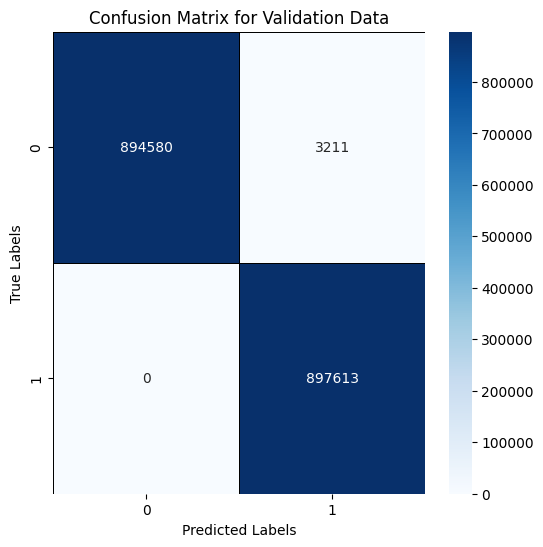

In [12]:
# First, get the predictions and actual labels from the validation set
val_preds, val_targets = learn.get_preds(dl=dls.valid)

# The actual labels (y_test_np)
y_test_np = val_targets.numpy()

# Predicted labels (convert probabilities to class indices)
y_pred_test_np = np.argmax(val_preds, axis=1).numpy()

# Calculate accuracy on the validation set
accuracy_val = accuracy_score(y_test_np, y_pred_test_np)
print(f"Validation Accuracy: {accuracy_val:.4f}")

# Plot the confusion matrix
conf_matrix_val = confusion_matrix(y_test_np, y_pred_test_np)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Validation Data')
plt.show()

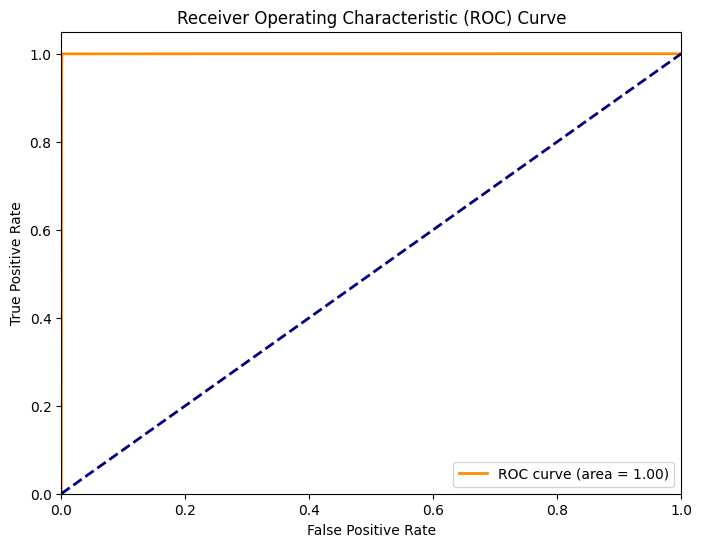

In [13]:
# Ensure val_targets is a numpy array
y_true = val_targets.numpy()

# Extract the probability scores for the positive class
y_scores = val_preds[:, 1].numpy()

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [14]:
# True Positives, False Positives, etc. from the confusion matrix
TP = conf_matrix_val[1, 1]
FP = conf_matrix_val[0, 1]
FN = conf_matrix_val[1, 0]
TN = conf_matrix_val[0, 0]

# Precision
precision = TP / (TP + FP)
# Recall
recall = TP / (TP + FN)
# F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision on Signal Predictions: {precision:.4f}")
print(f"Recall on Signal Predictions: {recall:.4f}")
print(f"F1-Score on Signal Predictions: {f1_score:.4f}")

Precision on Signal Predictions: 0.9964
Recall on Signal Predictions: 1.0000
F1-Score on Signal Predictions: 0.9982


In [17]:
# Free up RAM by deleting the dataframes
del df_background
del df_signal
del df_oversampled
gc.collect()

# Delete variables to free up memory
del X, y, to, dls, learn, lr_min, lr_steep